In [1]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import matplotlib.pyplot as plt

In [2]:
dataset_name = 'spark'
ped_files = ['../../DATA/spark/sparkfam.ped.quads.ped']
phase_dirs = ['../../PhasingFamilies/phased_spark_array_quads']
identicals_files = ['../../PhasingFamilies/phased_spark_array_quads/identicals.txt']
num_trials = 1000
interval_chrom, interval_start_pos, interval_end_pos = "10", None, None
na = 0

In [3]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_sex[pieces[3]] = '2'
			sample_to_sex[pieces[2]] = '1'
			sample_to_affected[pieces[1]] = pieces[5]
			parents_to_children[(pieces[0], pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children

In [4]:
Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 
                                 'num_affected', 'num_males', 
                                 'sibling1_aff', 'sibling2_aff', 'sibling1_male', 'sibling2_male'])
def pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sibling1, sibling2 = pieces[:2]
			leave_out.add((sibling1, sibling2))
			leave_out.add((sibling2, sibling1))


	# pull sibpairs with phase data
	sibpair_has_phase_data = set()
	family_to_inds = dict()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			try:
				with open('%s/%s' % (phase_dir, filename), 'r')  as f:
					header = next(f).strip().split('\t')
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for sibling1, sibling2 in combinations(individuals[2:], 2):
						if (sibling1, sibling2) not in leave_out:
							sibpair_has_phase_data.add((sibling1, sibling2))
							sibpair_has_phase_data.add((sibling2, sibling1))
			except StopIteration:
				pass



	def form_sibpair(family, sibling1, sibling2, mom, dad):
		return Sibpair(family, sibling1, sibling2, mom, dad,
			phase_dir,
			int(sample_to_affected[sibling1]=='2')+int(sample_to_affected[sibling2]=='2'),
			int(sample_to_sex[sibling1]=='1')+int(sample_to_sex[sibling2]=='1'),
			sample_to_affected[sibling1]=='2', sample_to_affected[sibling2]=='2',
			sample_to_sex[sibling1]=='1', sample_to_sex[sibling2]=='1')
	# pull sibpairs from families
	sibpairs = []
	for (family, mom, dad), children in parents_to_children.items():
		for sibling1, sibling2 in combinations([x for x in children if x in sample_to_affected], 2):
			if (sibling1, sibling2) in sibpair_has_phase_data:
				sibpairs.append(form_sibpair(family, sibling1, sibling2, mom, dad))
	sibpairs = sorted(sibpairs)

	for i in range(len(sibpairs)-1):
		if sibpairs[i] == sibpairs[i+1]:
			print(sibpairs[i])

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return sibpairs, family_to_inds

In [5]:
def pull_intervals(chrom, sibpairs, family_to_inds, interval_start_pos=None, interval_end_pos=None):

	positions = set()
	if interval_start_pos is not None:
		positions.add(interval_start_pos)
	if interval_end_pos is not None:
		positions.add(interval_end_pos)

	for sibpair_index, sibpair in enumerate(sibpairs):
		inds = family_to_inds[sibpair.family]
		sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
		sib1_mat_index, sib2_mat_index = 4+(2*sib1_ind_index), 4+(2*sib2_ind_index)
		sib1_pat_index, sib2_pat_index = 5+(2*sib1_ind_index), 5+(2*sib2_ind_index)
		sib_phase_indices = [sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index]
		

		with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
			next(f) # skip header

			prev_state = None
			for line in f:
				if line.startswith('chr%s\t'%chrom):
					pieces = line.strip().split('\t')
					
					start_pos, end_pos = [int(x) for x in pieces[-2:]]
					state = np.array([int(x) for x in pieces[1:-2]])

					if prev_state is None or not np.all(state[sib_phase_indices]==prev_state[sib_phase_indices]):
						prev_state = state
						if ((interval_start_pos is None) or start_pos >= interval_start_pos) and ((interval_end_pos is None) or start_pos <= interval_end_pos):
							positions.add(start_pos)
						if ((interval_start_pos is None) or end_pos >= interval_start_pos) and ((interval_end_pos is None) or end_pos <= interval_end_pos):
							positions.add(end_pos)

	return np.array(sorted(positions))
	#is_ok = np.ones((len(positions),), dtype=bool)
	#is_ok[np.where(positions[1:]-positions[:-1]<1000)[0]+1] = False
	#is_ok[0] = True
	#is_ok[-1] = True
	#return positions[is_ok]

In [6]:
def pull_sibpair_matches(sibpairs, family_to_inds, chroms, interval_bins, interval_chrom=None, interval_start_pos=None, interval_end_pos=None):
	sibpair_to_index = dict([((x.family, x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)])

	interval_start_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_bins[0, :]))])
	interval_end_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_bins[1, :]))])
	
	# pull phase data
	# sibpair, interval
	is_mat_match = np.zeros((len(sibpair_to_index), interval_bins.shape[1]), dtype=int)
	is_pat_match = np.zeros((len(sibpair_to_index), interval_bins.shape[1]), dtype=int)

	def update_matches(sibpair_index, chrom, start_pos, end_pos, state, sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index, interval_start_pos, interval_end_pos):
		if interval_start_pos is not None or interval_end_pos is not None:
			start_pos = np.clip(start_pos, interval_start_pos, interval_end_pos)
			end_pos = np.clip(end_pos, interval_start_pos, interval_end_pos)

		#if (chrom, start_pos) not in interval_start_to_index:
		#	index = np.where(chroms==chrom)[0][0]+np.searchsorted(interval_bins[0, chroms==chrom], start_pos)
		#	interval_start_to_index[(chrom, start_pos)] = index
		#	#print('start', chrom, start_pos, chroms[index], interval_bins[:, index])
		#
		#if (chrom, end_pos) not in interval_end_to_index:
		#	index = np.where(chroms==chrom)[0][0]+np.searchsorted(interval_bins[1, chroms==chrom], end_pos)
		#	interval_end_to_index[(chrom, end_pos)] = index-1
		#	#print('end', chrom, end_pos, chroms[index], interval_bins[:, index])
		start_index, end_index = interval_start_to_index[(chrom, start_pos)], interval_end_to_index[(chrom, end_pos)]+1
		
		if state[sib1_mat_index]==-1 or state[sib2_mat_index]==-1:
			pass
		elif state[sib1_mat_index]==state[sib2_mat_index]:
			is_mat_match[sibpair_index, start_index:end_index] = 1
		else:
			is_mat_match[sibpair_index, start_index:end_index] = -1
		if state[sib1_pat_index]==-1 or state[sib2_pat_index]==-1:
			pass
		elif state[sib1_pat_index]==state[sib2_pat_index]:
			is_pat_match[sibpair_index, start_index:end_index] = 1
		else:
			is_pat_match[sibpair_index, start_index:end_index] = -1

	for sibpair_index, sibpair in enumerate(sibpairs):
		inds = family_to_inds[sibpair.family]
		sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
		sib1_mat_index, sib2_mat_index = 4+(2*sib1_ind_index), 4+(2*sib2_ind_index)
		sib1_pat_index, sib2_pat_index = 5+(2*sib1_ind_index), 5+(2*sib2_ind_index)
		sib_phase_indices = [sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index]
		
		with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
			next(f) # skip header

			prev_chrom = None
			prev_state = None
			prev_start, prev_end = None, None
			for line in f:
				pieces = line.strip().split('\t')
				
				try:
					chrom = int(pieces[0][3:])
					start_pos, end_pos = [int(x) for x in pieces[-2:]]
					state = np.array([int(x) for x in pieces[1:-2]])


					if (prev_state is None) or (prev_chrom != chrom) or (not np.all(state[sib_phase_indices]==prev_state[sib_phase_indices])):
						# first save prev state
						if prev_state is not None and (interval_chrom is None or interval_chrom==str(prev_chrom)):
							update_matches(sibpair_index, prev_chrom, prev_start, prev_end, prev_state, 
								sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index,
								interval_start_pos, interval_end_pos)
						prev_state = state
						prev_chrom, prev_start, prev_end = chrom, start_pos, end_pos
					else:
						prev_end = end_pos
				except ValueError:
					pass
					

	return is_mat_match, is_pat_match

In [7]:
# pull ped info
sibpairs, family_to_inds = [], dict()
for ped_file, phase_dir, identicals_file in zip(ped_files, phase_dirs, identicals_files):
    sample_to_affected, sample_to_sex, parents_to_children= pull_phenotype_ped(ped_file)

    # pull sibpairs
    sps, f_to_i = pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file)
    sibpairs.extend(sps)
    family_to_inds.update(f_to_i)


print('Overall')
print('families', len(set([x.family.split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))

sibpairs = [x for x in sibpairs if x.num_affected==na]

print('Overall')
print('families', len(set([x.family.split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))

FileNotFoundError: [Errno 2] No such file or directory: '../../PhasingFamilies/phased_spark_array_quads/identicals.txt'

In [90]:
chroms, interval_bins_starts, interval_bins_ends = [], [], []
if interval_chrom is not None:
	interval_bins = pull_intervals(interval_chrom, sibpairs, family_to_inds, interval_start_pos, interval_end_pos)
	print(interval_chrom, 'intervals', len(interval_bins))

	chroms.append(int(interval_chrom)*np.ones((interval_bins.shape[0]-1,)))
	interval_bins_starts.append(interval_bins[:-1])
	interval_bins_ends.append(interval_bins[1:])
else:
	for chrom in [str(x) for x in range(1, 23)]:
		interval_bins = pull_intervals(chrom, sibpairs, family_to_inds, interval_start_pos, interval_end_pos)
		print(chrom, 'intervals', len(interval_bins))
		
		chroms.append(int(chrom)*np.ones((interval_bins.shape[0]-1,)))
		interval_bins_starts.append(interval_bins[:-1])
		interval_bins_ends.append(interval_bins[1:])

interval_bins = np.vstack((np.hstack(interval_bins_starts), np.hstack(interval_bins_ends)))
chroms = np.hstack(chroms)
print('intervals', interval_bins.shape)

10 intervals 1032
intervals (2, 1031)


In [91]:
is_mat_match, is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, chroms, interval_bins, interval_chrom, interval_start_pos, interval_end_pos)
is_ok = interval_bins[1, :] - interval_bins[0, :] > 1
interval_bins = interval_bins[:, is_ok]
chroms = chroms[is_ok]
is_mat_match = is_mat_match[:, is_ok]
is_pat_match = is_pat_match[:, is_ok]

print(is_mat_match.shape, is_pat_match.shape)

(127, 1016) (127, 1016)


In [97]:

print(sibpairs[0])

print('\nmat')
change_indices = np.where(is_mat_match[0, 1:] != is_mat_match[0, :-1])[0]
start_pos = interval_bins[0, 0]
for i in change_indices:
    print('%d-%d\t%d' % (start_pos, interval_bins[1, i], is_mat_match[0, i]))
    start_pos = interval_bins[0, i+1]
print('%d-%d\t%d' % (start_pos, interval_bins[1, -1], is_mat_match[0, -1]))

print('\npat')
change_indices = np.where(is_pat_match[0, 1:] != is_pat_match[0, :-1])[0]
start_pos = interval_bins[0, 0]
for i in change_indices:
    print('%d-%d\t%d' % (start_pos, interval_bins[1, i], is_pat_match[0, i]))
    start_pos = interval_bins[0, i+1]
print('%d-%d\t%d' % (start_pos, interval_bins[1, -1], is_pat_match[0, -1]))

Sibpair(family='SF0007020.SP0007521.SP0007599', sibling1='SP0007521', sibling2='SP0007599', mom='SP0006940', dad='SP0153276', phase_dir='../../PhasingFamilies/phased_spark_array_quads', num_affected=0, num_males=1, sibling1_aff=False, sibling2_aff=False, sibling1_male=True, sibling2_male=False)

mat
1-28817741	1
28817741-28894344	0
28894344-30735208	-1
30735208-30749824	0
30749824-90317519	1
90317519-90321337	0
90321337-119528991	-1
119528991-120390564	0
120390565-125328103	1
125328103-125557751	0
125557751-133797422	-1

pat
1-11248390	-1
11248390-11275395	0
11275395-131178256	1
131178256-131194640	0
131194640-133797422	-1


In [98]:
# take into account sibling structure across quads
individuals = sorted(set([x.sibling1 for x in sibpairs] + [x.sibling2 for x in sibpairs]))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
sibling1_indices = np.array([ind_to_index[x.sibling1] for x in sibpairs])
sibling2_indices = np.array([ind_to_index[x.sibling2] for x in sibpairs])

A = np.random.randint(0, high=2, size=(num_trials+1, len(individuals), 2))
X1 = (A[:, sibling1_indices, 0] == A[:, sibling2_indices, 0]).astype(int)
X2 = (A[:, sibling1_indices, 1] == A[:, sibling2_indices, 1]).astype(int)

# randomly flip IBD in sibpairs
#X1 = np.random.randint(0, high=2, size=(num_trials, len(sibpairs)))
#X2 = np.random.randint(0, high=2, size=(num_trials, len(sibpairs)))

X1[X1==0] = -1
X2[X2==0] = -1

# first entry is actual IBD relationships
X1[0, :] = 1
X2[0, :] = 1

#print(X.shape)
print('ready')

ready


In [99]:
if interval_chrom is not None:
	dataset_name += '.chr%s' % interval_chrom
if interval_start_pos is not None or interval_end_pos is not None:
	dataset_name += '.%d-%d' % (interval_start_pos, interval_end_pos)

#num_affected = np.array([x.num_affected for x in sibpairs])

In [100]:
# trial, interval, mat/pat
rand_pvalue = np.zeros((num_trials+1, interval_bins.shape[1], 3), dtype=int)

print(na, 'mat')
rand_pvalue[:, :, 0] = X1.dot(is_mat_match)
print(na, 'pat')
rand_pvalue[:, :, 1] = X2.dot(is_pat_match)
print(na, 'both')
rand_pvalue[:, :, 2] = rand_pvalue[:, :, 0]+rand_pvalue[:, :, 1]


# we expect to see less IBD sharing between discordant sibpairs
if na==1:
	rand_pvalue = -rand_pvalue

0 mat
0 pat
0 both


In [108]:
# -------------------- implementing Westfall-Young max T stepdown procedure

# indices are sorted along interval axis from interval with most IBD sharing
# to least IBD sharing
final_pvalues = np.zeros((interval_bins.shape[1], 3))
for is_mat in range(3):

	orig_indices = np.flip(np.argsort(rand_pvalue[0, :, is_mat]))

	max_t_k = np.zeros((num_trials+1, interval_bins.shape[1]+1))
	max_t_k[:, -1] = np.min(rand_pvalue[:, :, is_mat], axis=1)
	for i, j in list(reversed(list(enumerate(orig_indices)))):
		max_t_k[:, i] = np.maximum(max_t_k[:, i+1], rand_pvalue[:, j, is_mat])
	max_t_k = max_t_k[:, :-1]

	#max_t_k = np.flip(np.sort(rand_pvalue[:, :, is_mat], axis=1), axis=1)
	
	assert np.all(max_t_k[0, :] == rand_pvalue[0, orig_indices, is_mat])

	# calculate pi(j)
	pvalues = np.sum(max_t_k[1:, :] >= np.tile(max_t_k[0, :], (num_trials, 1)), axis=0)/num_trials
	pvalues = np.array([np.max(pvalues[:(i+1)]) for i in np.arange(pvalues.shape[0])])
	final_pvalues[orig_indices, is_mat] = pvalues

(array([936.,  24.,   7.,  16.,   0.,  16.,   5.,   4.,   0.,   8.]),
 array([0.        , 0.0489455 , 0.097891  , 0.1468365 , 0.195782  ,
        0.24472749, 0.29367299, 0.34261849, 0.39156399, 0.44050949,
        0.48945499]),
 <a list of 10 Patch objects>)

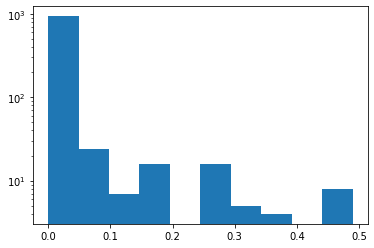

In [109]:
plt.hist(-np.log10(final_pvalues[:, 0]), log=True)

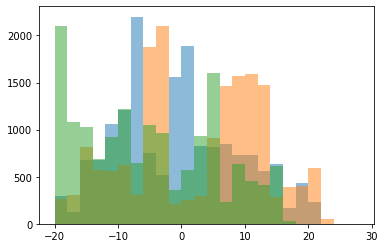

In [44]:
plt.hist(rand_pvalue[0, :, 1, 0], bins=np.arange(-20, 30, 2), alpha=0.5)
plt.hist(rand_pvalue[1, :, 1, 0], bins=np.arange(-20, 30, 2), alpha=0.5)
plt.hist(rand_pvalue[2, :, 1, 0], bins=np.arange(-20, 30, 2), alpha=0.5)

plt.show()

In [37]:
print(rand_pvalue[0, :, 0, 0])

[ 23  23  23 ... -11 -11 -11]
